In [ ]:
import os
import tkinter as tk
from tkinter import scrolledtext
from datetime import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, Flatten, Input, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
from scapy.all import sniff, IP, conf

# Directoare pentru model și logs
MODEL_DIR = os.path.join(".", "saved_model")
MODEL_FILE_PATH = os.path.join(MODEL_DIR, "model_traffic_final_model.h5")
LOG_DIR = os.path.join(".", "analysis_logs")

# Definirea coloanelor
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent',
           'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
           'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
           'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
           'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
           'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
           'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack', 'level']

# Funcție de grupare a etichetelor de atac în cele 5 categorii
def group_attack_label(attack):
    attack = attack.lower()
    if attack in ['satan', 'portsweep', 'nmap', 'jpsweep']:
        return 'Probe'
    elif attack in ['spy', 'phf', 'multihop', 'imap', 'guess_passwd', 'ftp_write', 'warezmaster', 'warezclient']:
        return 'R2L'
    elif attack in ['rootkit', 'perl', 'loadmodule', 'buffer_overflow']:
        return 'U2R'
    elif attack in ['teardrop', 'smurf', 'pod', 'neptune', 'land', 'back']:
        return 'DoS'
    elif attack == 'normal':
        return 'NORMAL'
    else:
        return 'NORMAL'

# Funcție de încărcare și preprocesare a datelor de antrenare
def load_and_preprocess_train_data(file_path):
    df = pd.read_csv(file_path, delimiter=',', header=None)
    df.columns = columns

    X = df.iloc[:, :-1]
    y_raw = df['attack'].apply(group_attack_label)

    label_encoders = {}
    for column in X.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column])
        label_encoders[column] = le

    label_encoder_y = LabelEncoder()
    y = label_encoder_y.fit_transform(y_raw)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
    return X_scaled, y, label_encoders, label_encoder_y, scaler

# Definirea unui bloc Inception pentru date 1D
def inception_block(x, filters):
    branch1 = Conv1D(filters, kernel_size=1, padding='same', activation='relu')(x)

    branch3 = Conv1D(filters, kernel_size=1, padding='same', activation='relu')(x)
    branch3 = Conv1D(filters, kernel_size=3, padding='same', activation='relu')(branch3)

    branch5 = Conv1D(filters, kernel_size=1, padding='same', activation='relu')(x)
    branch5 = Conv1D(filters, kernel_size=5, padding='same', activation='relu')(branch5)

    branch_pool = MaxPooling1D(pool_size=3, strides=1, padding='same')(x)
    branch_pool = Conv1D(filters, kernel_size=1, padding='same', activation='relu')(branch_pool)

    x = concatenate([branch1, branch3, branch5, branch_pool], axis=-1)
    return x

# Crearea modelului VGG16IncepNet pentru date 1D
def create_vgg16incepnet_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)  # Adăugare Dropout pentru regularizare

    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)  # Adăugare Dropout pentru regularizare

    x = inception_block(x, filters=64)
    x = Dropout(0.3)(x)  # Adăugare Dropout pentru regularizare

    x = Conv1D(256, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv1D(256, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)  # Adăugare Dropout pentru regularizare

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.summary()  # Afișează sumarul modelului în consolă

    # Ajustarea ratei de învățare
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

# Încărcare și pregătire date
train_file = "../Data/nsl-kdd/KDDTrain+.txt"
test_file = "../Data/nsl-kdd/KDDTest+.txt"

X_train, y_train, label_encoders, label_encoder_y, scaler = load_and_preprocess_train_data(train_file)
num_classes = len(np.unique(y_train))

if os.path.exists(MODEL_FILE_PATH):
    model = load_model(MODEL_FILE_PATH, compile=False)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
    model.summary()
    print("Modelul a fost încărcat din fișierul salvat.")
else:
    os.makedirs(MODEL_DIR, exist_ok=True)
    model = create_vgg16incepnet_model(X_train.shape[1:], num_classes)

    # Adăugare Early Stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitorizează loss-ul pe setul de validare
        patience=10,        # Numărul de epochs fără îmbunătățire înainte de oprire
        restore_best_weights=True  # Restorează cele mai bune greutăți
    )

    # Antrenare model
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,  # Folosește 20% din date pentru validare
        callbacks=[early_stopping]  # Adăugă callback-ul de Early Stopping
    )

    model.save(MODEL_FILE_PATH)
    model.summary()
    print("Modelul a fost antrenat și salvat în format .h5.")

    # Afișarea curbelor de antrenare
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Funcție de preprocesare și predicție pentru datele capturate live
def preprocess_and_predict(packet, threshold=50):
    # Extrage caracteristicile din pachet
    features = extract_features(packet)
    features_scaled = scaler.transform(features.reshape(1, -1))
    features_scaled = features_scaled.reshape(1, features_scaled.shape[1], 1)

    prediction_probs = model.predict(features_scaled)[0]
    predicted_index = np.argmax(prediction_probs)
    confidence = prediction_probs[predicted_index] * 100
    if confidence < threshold:
        return "Trafic Legitim", confidence
    predicted_category = label_encoder_y.inverse_transform([predicted_index])[0]
    return f"Atac: {predicted_category}", confidence

# Funcție de extragere a caracteristicilor dintr-un pachet
def extract_features(packet):
    # Implementează extragerea caracteristicilor din pachet
    # Aici trebuie să extragi caracteristicile necesare pentru modelul tău
    # De exemplu, poți extrage informații despre protocol, sursă, destinație, etc.
    features = {
        'duration': 0,  # Exemplu de caracteristică
        'protocol_type': 0,
        'service': 0,
        'flag': 0,
        'src_bytes': 0,
        'dst_bytes': 0,
        'land': 0,
        'wrong_fragment': 0,
        'urgent': 0,
        'hot': 0,
        'num_failed_logins': 0,
        'logged_in': 0,
        'num_compromised': 0,
        'root_shell': 0,
        'su_attempted': 0,
        'num_root': 0,
        'num_file_creations': 0,
        'num_shells': 0,
        'num_access_files': 0,
        'num_outbound_cmds': 0,
        'is_host_login': 0,
        'is_guest_login': 0,
        'count': 0,
        'srv_count': 0,
        'serror_rate': 0,
        'srv_serror_rate': 0,
        'rerror_rate': 0,
        'srv_rerror_rate': 0,
        'same_srv_rate': 0,
        'diff_srv_rate': 0,
        'srv_diff_host_rate': 0,
        'dst_host_count': 0,
        'dst_host_srv_count': 0,
        'dst_host_same_srv_rate': 0,
        'dst_host_diff_srv_rate': 0,
        'dst_host_same_src_port_rate': 0,
        'dst_host_srv_diff_host_rate': 0,
        'dst_host_serror_rate': 0,
        'dst_host_srv_serror_rate': 0,
        'dst_host_rerror_rate': 0,
        'dst_host_srv_rerror_rate': 0,
        'attack': 0,
        'level': 0
    }
    return pd.DataFrame([features])

# Funcție de salvare a atacurilor detectate într-un fișier text
def save_attack_to_file(log_file, attack_type, confidence, packet_data):
    current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    with open(log_file, 'a', encoding="utf-8") as file:
        file.write(f"{current_time}\t{attack_type}\t\t{confidence:.2f}%\n")
        file.write(f"Packet Data: {packet_data}\n")
        file.write("-"*60 + "\n")

# Interfața Tkinter pentru analiza traficului
class LiveTrafficAnalyzer:
    def __init__(self, root):
        self.root = root
        self.root.title("Live Internet Traffic Analyzer")

        self.label = tk.Label(root, text="Internet Traffic Analysis", font=("Arial", 16))
        self.label.pack(pady=10)

        # Butoane de start și stop
        self.start_button = tk.Button(root, text="Start Analysis", command=self.start_analysis)
        self.start_button.pack(pady=5)
        self.stop_button = tk.Button(root, text="Stop Analysis", command=self.stop_analysis, state="disabled")
        self.stop_button.pack(pady=5)

        # Zonă pentru istoricul clasificărilor
        self.history_text = scrolledtext.ScrolledText(root, width=80, height=10, font=("Arial", 10))
        self.history_text.pack(pady=10)
        self.history_text.insert(tk.END, "Timestamp\t\tPredicted Attack Type\t\tConfidence (%)\n")
        self.history_text.insert(tk.END, "-"*60 + "\n")

        # Zonă pentru afișarea detaliilor pachetului de date
        self.packet_text = scrolledtext.ScrolledText(root, width=80, height=10, font=("Arial", 10))
        self.packet_text.pack(pady=10)
        self.packet_text.insert(tk.END, "Detalii pachet:\n")
        self.packet_text.insert(tk.END, "-"*60 + "\n")

        self.running = False
        self.log_file = None  # Fișier pentru salvarea log-urilor

    def start_analysis(self):
        self.running = True
        self.start_button.config(state="disabled")
        self.stop_button.config(state="normal")
        # Creează un folder cu un nume bazat pe intervalul orar al începutului analizei
        os.makedirs(LOG_DIR, exist_ok=True)
        self.log_file = os.path.join(LOG_DIR, f"analysis_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt")
        self.run_analysis()

    def stop_analysis(self):
        self.running = False
        self.start_button.config(state="normal")
        self.stop_button.config(state="disabled")

    def run_analysis(self):
        if self.running:
            # Captură pachete live la nivelul 3 (IP)
            sniff(filter="ip", prn=self.process_packet, count=1, iface=conf.L3socket)
            self.root.after(1000, self.run_analysis)

    def process_packet(self, packet):
        if IP in packet:
            attack_type, confidence = preprocess_and_predict(packet)
            current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            # Actualizează istoricul în interfață
            self.history_text.insert(tk.END, f"{current_time}\t{attack_type}\t\t{confidence:.2f}%\n")
            self.history_text.see(tk.END)

            # Preluăm datele brute ale pachetului corespunzător indexului ales
            packet_details = str(packet.show())
            # Construim un string cu pachetul de date pe un singur rând, separate prin " | "
            details_str = "Pachetul de date: " + packet_details
            self.packet_text.delete("1.0", tk.END)
            self.packet_text.insert(tk.END, details_str + "\n" + "-"*60 + "\n")

            # Salvăm rezultatul analizei într-un fișier text
            save_attack_to_file(self.log_file, attack_type, confidence, details_str)

# Inițializarea și rularea aplicației Tkinter
root = tk.Tk()
app = LiveTrafficAnalyzer(root)
root.mainloop()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 42, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 42, 64)    │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 42, 64)    │     12,352 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 21, 64)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 21, 64)    │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 21, 128)   │     24,704 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 21, 128)   │     49,280 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 10, 128)   │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 128)   │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 10, 64)    │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 10, 64)    │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 10, 128)   │          0 │ dropout_1[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 64)    │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 10, 64)    │     12,352 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 10, 64)    │     20,544 │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 10, 64)    │      8,256 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10, 256)   │          0 │ conv1d_4[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_6[0][0],   │
│                     │                   │            │ conv1d_8[0][0],   │
│                     │                   │            │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 10, 256)   │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 10, 256)   │    196,864 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 10, 256)   │    196,864 │ conv1d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 5, 256)    │          0 │ conv1d_11[0][0]   │
│ (MaxPooling1D)      │                   │            │                 

 Total params: 1,204,677 (4.60 MB)

 Trainable params: 1,204,677 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 2:40:06 3s/step - accuracy: 0.2812 - loss: 1.61 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - accuracy: 0.3136 - loss: 1.6030 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - accuracy: 0.3765 - loss: 1.58 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.4194 - loss: 1.56 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.4476 - loss: 1.53 ━━━━━━━━━━━━━━━━━━━━ 36s 12ms/step - accuracy: 0.4669 - loss: 1.50 ━━━━━━━━━━━━━━━━━━━━ 36s 12ms/step - accuracy: 0.4810 - loss: 1.47 ━━━━━━━━━━━━━━━━━━━━ 36s 12ms/step - accuracy: 0.4901 - loss: 1.44 ━━━━━━━━━━━━━━━━━━━━ 36s 12ms/step - accuracy: 0.4996 - loss: 1.41 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - accuracy: 0.5099 - loss: 1.37 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - accuracy: 0.5207 - loss: 1.34 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - accuracy: 0.5292 - loss: 1.32 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - accuracy: 0.5385 - loss: 1.29 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - accuracy: 0.5459 - loss: 1.27 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - 

In [36]:
import os
import tkinter as tk
from tkinter import scrolledtext
from datetime import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, Flatten, Input, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
from scapy.all import sniff, IP

MODEL_DIR = os.path.join(".", "saved_model")
MODEL_FILE_PATH = os.path.join(MODEL_DIR, "model_traffic_final_model.h5")
LOG_DIR = os.path.join(".", "analysis_logs")

# Definirea coloanelor
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent',
           'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
           'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
           'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
           'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
           'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
           'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack', 'level']

# Funcție de grupare a etichetelor de atac în cele 5 categorii
def group_attack_label(attack):
    attack = attack.lower()
    if attack in ['satan', 'portsweep', 'nmap', 'jpsweep']:
        return 'Probe'
    elif attack in ['spy', 'phf', 'multihop', 'imap', 'guess_passwd', 'ftp_write', 'warezmaster', 'warezclient']:
        return 'R2L'
    elif attack in ['rootkit', 'perl', 'loadmodule', 'buffer_overflow']:
        return 'U2R'
    elif attack in ['teardrop', 'smurf', 'pod', 'neptune', 'land', 'back']:
        return 'DoS'
    elif attack == 'normal':
        return 'NORMAL'
    else:
        return 'NORMAL'

# Funcție de încărcare și preprocesare a datelor de antrenare
def load_and_preprocess_train_data(file_path):
    df = pd.read_csv(file_path, delimiter=',', header=None)
    df.columns = columns

    X = df.iloc[:, :-1]
    y_raw = df['attack'].apply(group_attack_label)

    label_encoders = {}
    for column in X.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column])
        label_encoders[column] = le

    label_encoder_y = LabelEncoder()
    y = label_encoder_y.fit_transform(y_raw)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
    return X_scaled, y, label_encoders, label_encoder_y, scaler

# Definirea unui bloc Inception pentru date 1D
def inception_block(x, filters):
    branch1 = Conv1D(filters, kernel_size=1, padding='same', activation='relu')(x)

    branch3 = Conv1D(filters, kernel_size=1, padding='same', activation='relu')(x)
    branch3 = Conv1D(filters, kernel_size=3, padding='same', activation='relu')(branch3)

    branch5 = Conv1D(filters, kernel_size=1, padding='same', activation='relu')(x)
    branch5 = Conv1D(filters, kernel_size=5, padding='same', activation='relu')(branch5)

    branch_pool = MaxPooling1D(pool_size=3, strides=1, padding='same')(x)
    branch_pool = Conv1D(filters, kernel_size=1, padding='same', activation='relu')(branch_pool)

    x = concatenate([branch1, branch3, branch5, branch_pool], axis=-1)
    return x

# Crearea modelului VGG16IncepNet pentru date 1D
def create_vgg16incepnet_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)  # Adăugare Dropout pentru regularizare

    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)  # Adăugare Dropout pentru regularizare

    x = inception_block(x, filters=64)
    x = Dropout(0.3)(x)  # Adăugare Dropout pentru regularizare

    x = Conv1D(256, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv1D(256, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)  # Adăugare Dropout pentru regularizare

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.summary()  # Afișează sumarul modelului în consolă

    # Ajustarea ratei de învățare
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

# Încărcare și pregătire date
train_file = "../Data/nsl-kdd/KDDTrain+.txt"
test_file = "../Data/nsl-kdd/KDDTest+.txt"

X_train, y_train, label_encoders, label_encoder_y, scaler = load_and_preprocess_train_data(train_file)
num_classes = len(np.unique(y_train))

if os.path.exists(MODEL_FILE_PATH):
    model = load_model(MODEL_FILE_PATH, compile=False)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
    model.summary()
    print("Modelul a fost încărcat din fișierul salvat.")
else:
    os.makedirs(MODEL_DIR, exist_ok=True)
    model = create_vgg16incepnet_model(X_train.shape[1:], num_classes)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32,
              validation_split=0.2, callbacks=[early_stopping])
    model.save(MODEL_FILE_PATH)
    model.summary()
    print("Modelul a fost antrenat și salvat în format .h5.")

    # Afișarea curbelor de antrenare
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Funcție de preprocesare și predicție pentru datele capturate live
def preprocess_and_predict(packet, threshold=50):
    # Extrage caracteristicile din pachet
    features = extract_features(packet)
    features_scaled = scaler.transform(features.reshape(1, -1))
    features_scaled = features_scaled.reshape(1, features_scaled.shape[1], 1)

    prediction_probs = model.predict(features_scaled)[0]
    predicted_index = np.argmax(prediction_probs)
    confidence = prediction_probs[predicted_index] * 100
    if confidence < threshold:
        return "Trafic Legitim", confidence
    predicted_category = label_encoder_y.inverse_transform([predicted_index])[0]
    return f"Atac: {predicted_category}", confidence

# Funcție de extragere a caracteristicilor dintr-un pachet
def extract_features(packet):
    # Implementează extragerea caracteristicilor din pachet
    # Aici trebuie să extragi caracteristicile necesare pentru modelul tău
    # De exemplu, poți extrage informații despre protocol, sursă, destinație, etc.
    features = {
        'duration': 0,  # Exemplu de caracteristică
        'protocol_type': 0,
        'service': 0,
        'flag': 0,
        'src_bytes': 0,
        'dst_bytes': 0,
        'land': 0,
        'wrong_fragment': 0,
        'urgent': 0,
        'hot': 0,
        'num_failed_logins': 0,
        'logged_in': 0,
        'num_compromised': 0,
        'root_shell': 0,
        'su_attempted': 0,
        'num_root': 0,
        'num_file_creations': 0,
        'num_shells': 0,
        'num_access_files': 0,
        'num_outbound_cmds': 0,
        'is_host_login': 0,
        'is_guest_login': 0,
        'count': 0,
        'srv_count': 0,
        'serror_rate': 0,
        'srv_serror_rate': 0,
        'rerror_rate': 0,
        'srv_rerror_rate': 0,
        'same_srv_rate': 0,
        'diff_srv_rate': 0,
        'srv_diff_host_rate': 0,
        'dst_host_count': 0,
        'dst_host_srv_count': 0,
        'dst_host_same_srv_rate': 0,
        'dst_host_diff_srv_rate': 0,
        'dst_host_same_src_port_rate': 0,
        'dst_host_srv_diff_host_rate': 0,
        'dst_host_serror_rate': 0,
        'dst_host_srv_serror_rate': 0,
        'dst_host_rerror_rate': 0,
        'dst_host_srv_rerror_rate': 0,
        'attack': 0,
        'level': 0
    }
    return pd.DataFrame([features])

# Funcție de salvare a atacurilor detectate într-un fișier text
def save_attack_to_file(log_file, attack_type, confidence, packet_data):
    current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    with open(log_file, 'a', encoding="utf-8") as file:
        file.write(f"{current_time}\t{attack_type}\t\t{confidence:.2f}%\n")
        file.write(f"Packet Data: {packet_data}\n")
        file.write("-"*60 + "\n")

# Interfața Tkinter pentru analiza traficului
class LiveTrafficAnalyzer:
    def __init__(self, root):
        self.root = root
        self.root.title("Live Internet Traffic Analyzer")

        self.label = tk.Label(root, text="Internet Traffic Analysis", font=("Arial", 16))
        self.label.pack(pady=10)

        # Butoane de start și stop
        self.start_button = tk.Button(root, text="Start Analysis", command=self.start_analysis)
        self.start_button.pack(pady=5)
        self.stop_button = tk.Button(root, text="Stop Analysis", command=self.stop_analysis, state="disabled")
        self.stop_button.pack(pady=5)

        # Zonă pentru istoricul clasificărilor
        self.history_text = scrolledtext.ScrolledText(root, width=80, height=10, font=("Arial", 10))
        self.history_text.pack(pady=10)
        self.history_text.insert(tk.END, "Timestamp\t\tPredicted Attack Type\t\tConfidence (%)\n")
        self.history_text.insert(tk.END, "-"*60 + "\n")

        # Zonă pentru afișarea detaliilor pachetului de date
        self.packet_text = scrolledtext.ScrolledText(root, width=80, height=10, font=("Arial", 10))
        self.packet_text.pack(pady=10)
        self.packet_text.insert(tk.END, "Detalii pachet:\n")
        self.packet_text.insert(tk.END, "-"*60 + "\n")

        self.running = False
        self.log_file = None  # Fișier pentru salvarea log-urilor

    def start_analysis(self):
        self.running = True
        self.start_button.config(state="disabled")
        self.stop_button.config(state="normal")
        # Creează un folder cu un nume bazat pe intervalul orar al începutului analizei
        os.makedirs(LOG_DIR, exist_ok=True)
        self.log_file = os.path.join(LOG_DIR, f"analysis_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt")
        self.run_analysis()

    def stop_analysis(self):
        self.running = False
        self.start_button.config(state="normal")
        self.stop_button.config(state="disabled")

    def run_analysis(self):
        if self.running:
            # Captură pachete live la nivelul 3 (IP)
            sniff(filter="ip", prn=self.process_packet, count=1, iface="Wi-Fi")
            self.root.after(1000, self.run_analysis)

    def process_packet(self, packet):
        if IP in packet:
            attack_type, confidence = preprocess_and_predict(packet)
            current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            # Actualizează istoricul în interfață
            self.history_text.insert(tk.END, f"{current_time}\t{attack_type}\t\t{confidence:.2f}%\n")
            self.history_text.see(tk.END)

            # Preluăm datele brute ale pachetului corespunzător indexului ales
            packet_details = str(packet.show())
            # Construim un string cu pachetul de date pe un singur rând, separate prin " | "
            details_str = "Pachetul de date: " + packet_details
            self.packet_text.delete("1.0", tk.END)
            self.packet_text.insert(tk.END, details_str + "\n" + "-"*60 + "\n")

            # Salvăm rezultatul analizei într-un fișier text
            save_attack_to_file(self.log_file, attack_type, confidence, details_str)

# Inițializarea și rularea aplicației Tkinter
root = tk.Tk()
app = LiveTrafficAnalyzer(root)
root.mainloop()


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 42, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 42, 64)    │        256 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 42, 64)    │     12,352 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 21, 64)    │          0 │ conv1d_7[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 21, 128)   │     24,704 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 21, 128)   │     49,280 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 10, 128)   │          0 │ conv1d_9[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 10, 64)    │      8,256 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 10, 64)    │      8,256 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 10, 128)   │          0 │ max_pooling1d_3[… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 10, 64)    │      8,256 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 10, 64)    │     12,352 │ conv1d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 10, 64)    │     20,544 │ conv1d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 10, 64)    │      8,256 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10, 256)   │          0 │ conv1d_10[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_12[0][0],  │
│                     │                   │            │ conv1d_14[0][0],  │
│                     │                   │            │ conv1d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 10, 256)   │    196,864 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 10, 256)   │    196,864 │ conv1d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 5, 256)    │          0 │ conv1d_17[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1280)      │          0 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    655,872 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ dense_2[0][0]   

 Total params: 1,204,677 (4.60 MB)

 Trainable params: 1,204,677 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

Modelul a fost încărcat din fișierul salvat.


Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\Here\anaconda3\envs\gputf3.10\lib\tkinter\__init__.py", line 1921, in __call__
    return self.func(*args)
  File "C:\Users\Here\AppData\Local\Temp\ipykernel_20384\1539786448.py", line 271, in start_analysis
    self.run_analysis()
  File "C:\Users\Here\AppData\Local\Temp\ipykernel_20384\1539786448.py", line 281, in run_analysis
    sniff(filter="ip", prn=self.process_packet, count=1, iface="Wi-Fi")
  File "c:\Users\Here\anaconda3\envs\gputf3.10\lib\site-packages\scapy\sendrecv.py", line 1424, in sniff
    sniffer._run(*args, **kwargs)
  File "c:\Users\Here\anaconda3\envs\gputf3.10\lib\site-packages\scapy\sendrecv.py", line 1273, in _run
    sniff_sockets[_RL2(iface)(type=ETH_P_ALL, iface=iface,
  File "c:\Users\Here\anaconda3\envs\gputf3.10\lib\site-packages\scapy\arch\windows\__init__.py", line 1027, in __init__
    raise RuntimeError(
RuntimeError: Sniffing and sending packets is not available at layer

In [34]:
import os
import tkinter as tk
from tkinter import scrolledtext
from datetime import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, Flatten, Input, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
from scapy.all import sniff, IP

MODEL_DIR = os.path.join(".", "saved_model")
MODEL_FILE_PATH = os.path.join(MODEL_DIR, "model_traffic_final_model.h5")
LOG_DIR = os.path.join(".", "analysis_logs")

# Definirea coloanelor
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent',
           'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
           'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
           'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
           'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
           'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
           'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack', 'level']

# Funcție de grupare a etichetelor de atac în cele 5 categorii
def group_attack_label(attack):
    attack = attack.lower()
    if attack in ['satan', 'portsweep', 'nmap', 'jpsweep']:
        return 'Probe'
    elif attack in ['spy', 'phf', 'multihop', 'imap', 'guess_passwd', 'ftp_write', 'warezmaster', 'warezclient']:
        return 'R2L'
    elif attack in ['rootkit', 'perl', 'loadmodule', 'buffer_overflow']:
        return 'U2R'
    elif attack in ['teardrop', 'smurf', 'pod', 'neptune', 'land', 'back']:
        return 'DoS'
    elif attack == 'normal':
        return 'NORMAL'
    else:
        return 'NORMAL'

# Funcție de încărcare și preprocesare a datelor de antrenare
def load_and_preprocess_train_data(file_path):
    df = pd.read_csv(file_path, delimiter=',', header=None)
    df.columns = columns

    X = df.iloc[:, :-1]
    y_raw = df['attack'].apply(group_attack_label)

    label_encoders = {}
    for column in X.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column])
        label_encoders[column] = le

    label_encoder_y = LabelEncoder()
    y = label_encoder_y.fit_transform(y_raw)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
    return X_scaled, y, label_encoders, label_encoder_y, scaler

# Definirea unui bloc Inception pentru date 1D
def inception_block(x, filters):
    branch1 = Conv1D(filters, kernel_size=1, padding='same', activation='relu')(x)

    branch3 = Conv1D(filters, kernel_size=1, padding='same', activation='relu')(x)
    branch3 = Conv1D(filters, kernel_size=3, padding='same', activation='relu')(branch3)

    branch5 = Conv1D(filters, kernel_size=1, padding='same', activation='relu')(x)
    branch5 = Conv1D(filters, kernel_size=5, padding='same', activation='relu')(branch5)

    branch_pool = MaxPooling1D(pool_size=3, strides=1, padding='same')(x)
    branch_pool = Conv1D(filters, kernel_size=1, padding='same', activation='relu')(branch_pool)

    x = concatenate([branch1, branch3, branch5, branch_pool], axis=-1)
    return x

# Crearea modelului VGG16IncepNet pentru date 1D
def create_vgg16incepnet_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)  # Adăugare Dropout pentru regularizare

    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)  # Adăugare Dropout pentru regularizare

    x = inception_block(x, filters=64)
    x = Dropout(0.3)(x)  # Adăugare Dropout pentru regularizare

    x = Conv1D(256, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv1D(256, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)  # Adăugare Dropout pentru regularizare

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.summary()  # Afișează sumarul modelului în consolă

    # Ajustarea ratei de învățare
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

# Încărcare și pregătire date
train_file = "../Data/nsl-kdd/KDDTrain+.txt"
test_file = "../Data/nsl-kdd/KDDTest+.txt"

X_train, y_train, label_encoders, label_encoder_y, scaler = load_and_preprocess_train_data(train_file)
num_classes = len(np.unique(y_train))

if os.path.exists(MODEL_FILE_PATH):
    model = load_model(MODEL_FILE_PATH, compile=False)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
    model.summary()
    print("Modelul a fost încărcat din fișierul salvat.")
else:
    os.makedirs(MODEL_DIR, exist_ok=True)
    model = create_vgg16incepnet_model(X_train.shape[1:], num_classes)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32,
              validation_split=0.2, callbacks=[early_stopping])
    model.save(MODEL_FILE_PATH)
    model.summary()
    print("Modelul a fost antrenat și salvat în format .h5.")

    # Afișarea curbelor de antrenare
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Funcție de preprocesare și predicție pentru datele capturate live
def preprocess_and_predict(packet, threshold=50):
    # Extrage caracteristicile din pachet
    features = extract_features(packet)
    features_scaled = scaler.transform(features.reshape(1, -1))
    features_scaled = features_scaled.reshape(1, features_scaled.shape[1], 1)

    prediction_probs = model.predict(features_scaled)[0]
    predicted_index = np.argmax(prediction_probs)
    confidence = prediction_probs[predicted_index] * 100
    if confidence < threshold:
        return "Trafic Legitim", confidence
    predicted_category = label_encoder_y.inverse_transform([predicted_index])[0]
    return f"Atac: {predicted_category}", confidence

# Funcție de extragere a caracteristicilor dintr-un pachet
def extract_features(packet):
    # Implementează extragerea caracteristicilor din pachet
    # Aici trebuie să extragi caracteristicile necesare pentru modelul tău
    # De exemplu, poți extrage informații despre protocol, sursă, destinație, etc.
    features = {
        'duration': 0,  # Exemplu de caracteristică
        'protocol_type': 0,
        'service': 0,
        'flag': 0,
        'src_bytes': 0,
        'dst_bytes': 0,
        'land': 0,
        'wrong_fragment': 0,
        'urgent': 0,
        'hot': 0,
        'num_failed_logins': 0,
        'logged_in': 0,
        'num_compromised': 0,
        'root_shell': 0,
        'su_attempted': 0,
        'num_root': 0,
        'num_file_creations': 0,
        'num_shells': 0,
        'num_access_files': 0,
        'num_outbound_cmds': 0,
        'is_host_login': 0,
        'is_guest_login': 0,
        'count': 0,
        'srv_count': 0,
        'serror_rate': 0,
        'srv_serror_rate': 0,
        'rerror_rate': 0,
        'srv_rerror_rate': 0,
        'same_srv_rate': 0,
        'diff_srv_rate': 0,
        'srv_diff_host_rate': 0,
        'dst_host_count': 0,
        'dst_host_srv_count': 0,
        'dst_host_same_srv_rate': 0,
        'dst_host_diff_srv_rate': 0,
        'dst_host_same_src_port_rate': 0,
        'dst_host_srv_diff_host_rate': 0,
        'dst_host_serror_rate': 0,
        'dst_host_srv_serror_rate': 0,
        'dst_host_rerror_rate': 0,
        'dst_host_srv_rerror_rate': 0,
        'attack': 0,
        'level': 0
    }
    return pd.DataFrame([features])

# Funcție de salvare a atacurilor detectate într-un fișier text
def save_attack_to_file(log_file, attack_type, confidence, packet_data):
    current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    with open(log_file, 'a', encoding="utf-8") as file:
        file.write(f"{current_time}\t{attack_type}\t\t{confidence:.2f}%\n")
        file.write(f"Packet Data: {packet_data}\n")
        file.write("-"*60 + "\n")

# Interfața Tkinter pentru analiza traficului
class LiveTrafficAnalyzer:
    def __init__(self, root):
        self.root = root
        self.root.title("Live Internet Traffic Analyzer")

        self.label = tk.Label(root, text="Internet Traffic Analysis", font=("Arial", 16))
        self.label.pack(pady=10)

        # Butoane de start și stop
        self.start_button = tk.Button(root, text="Start Analysis", command=self.start_analysis)
        self.start_button.pack(pady=5)
        self.stop_button = tk.Button(root, text="Stop Analysis", command=self.stop_analysis, state="disabled")
        self.stop_button.pack(pady=5)

        # Zonă pentru istoricul clasificărilor
        self.history_text = scrolledtext.ScrolledText(root, width=80, height=10, font=("Arial", 10))
        self.history_text.pack(pady=10)
        self.history_text.insert(tk.END, "Timestamp\t\tPredicted Attack Type\t\tConfidence (%)\n")
        self.history_text.insert(tk.END, "-"*60 + "\n")

        # Zonă pentru afișarea detaliilor pachetului de date
        self.packet_text = scrolledtext.ScrolledText(root, width=80, height=10, font=("Arial", 10))
        self.packet_text.pack(pady=10)
        self.packet_text.insert(tk.END, "Detalii pachet:\n")
        self.packet_text.insert(tk.END, "-"*60 + "\n")

        self.running = False
        self.log_file = None  # Fișier pentru salvarea log-urilor

    def start_analysis(self):
        self.running = True
        self.start_button.config(state="disabled")
        self.stop_button.config(state="normal")
        # Creează un folder cu un nume bazat pe intervalul orar al începutului analizei
        os.makedirs(LOG_DIR, exist_ok=True)
        self.log_file = os.path.join(LOG_DIR, f"analysis_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt")
        self.run_analysis()

    def stop_analysis(self):
        self.running = False
        self.start_button.config(state="normal")
        self.stop_button.config(state="disabled")

    def run_analysis(self):
        if self.running:
            # Captură pachete live la nivelul 3 (IP)
            sniff(filter="ip", prn=self.process_packet, count=1, iface="YourNetworkInterface")
            self.root.after(1000, self.run_analysis)

    def process_packet(self, packet):
        if IP in packet:
            attack_type, confidence = preprocess_and_predict(packet)
            current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            # Actualizează istoricul în interfață
            self.history_text.insert(tk.END, f"{current_time}\t{attack_type}\t\t{confidence:.2f}%\n")
            self.history_text.see(tk.END)

            # Preluăm datele brute ale pachetului corespunzător indexului ales
            packet_details = str(packet.show())
            # Construim un string cu pachetul de date pe un singur rând, separate prin " | "
            details_str = "Pachetul de date: " + packet_details
            self.packet_text.delete("1.0", tk.END)
            self.packet_text.insert(tk.END, details_str + "\n" + "-"*60 + "\n")

            # Salvăm rezultatul analizei într-un fișier text
            save_attack_to_file(self.log_file, attack_type, confidence, details_str)

# Inițializarea și rularea aplicației Tkinter
root = tk.Tk()
app = LiveTrafficAnalyzer(root)
root.mainloop()


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 42, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 42, 64)    │        256 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 42, 64)    │     12,352 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 21, 64)    │          0 │ conv1d_7[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 21, 128)   │     24,704 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 21, 128)   │     49,280 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 10, 128)   │          0 │ conv1d_9[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 10, 64)    │      8,256 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 10, 64)    │      8,256 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 10, 128)   │          0 │ max_pooling1d_3[… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 10, 64)    │      8,256 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 10, 64)    │     12,352 │ conv1d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 10, 64)    │     20,544 │ conv1d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 10, 64)    │      8,256 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10, 256)   │          0 │ conv1d_10[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_12[0][0],  │
│                     │                   │            │ conv1d_14[0][0],  │
│                     │                   │            │ conv1d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 10, 256)   │    196,864 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 10, 256)   │    196,864 │ conv1d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 5, 256)    │          0 │ conv1d_17[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1280)      │          0 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    655,872 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ dense_2[0][0]   

 Total params: 1,204,677 (4.60 MB)

 Trainable params: 1,204,677 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

Modelul a fost încărcat din fișierul salvat.


Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\Here\anaconda3\envs\gputf3.10\lib\tkinter\__init__.py", line 1921, in __call__
    return self.func(*args)
  File "C:\Users\Here\AppData\Local\Temp\ipykernel_20384\1532335751.py", line 271, in start_analysis
    self.run_analysis()
  File "C:\Users\Here\AppData\Local\Temp\ipykernel_20384\1532335751.py", line 281, in run_analysis
    sniff(filter="ip", prn=self.process_packet, count=1, iface="YourNetworkInterface")
  File "c:\Users\Here\anaconda3\envs\gputf3.10\lib\site-packages\scapy\sendrecv.py", line 1424, in sniff
    sniffer._run(*args, **kwargs)
  File "c:\Users\Here\anaconda3\envs\gputf3.10\lib\site-packages\scapy\sendrecv.py", line 1273, in _run
    sniff_sockets[_RL2(iface)(type=ETH_P_ALL, iface=iface,
  File "c:\Users\Here\anaconda3\envs\gputf3.10\lib\site-packages\scapy\sendrecv.py", line 1258, in <lambda>
    _RL2 = lambda i: L2socket or resolve_iface(i).l2listen()  # type: Callable[[_GlobInter

# Cod pentru a testa, pe setul de antrenare, acuratețea și latența

In [31]:
import os
import tkinter as tk
from tkinter import scrolledtext
from datetime import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Convolution1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

MODEL_DIR = os.path.join(".", "saved_model")
MODEL_FILE_PATH = os.path.join(MODEL_DIR, "model_traffic_25.03.h5")

# Definirea coloanelor
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent',
           'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
           'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
           'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
           'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
           'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
           'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack', 'level']

# Funcție de încărcare și preprocesare a datelor NSL-KDD
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path, delimiter=',', header=None)
    df.columns = columns  # Setează numele coloanelor

    X = df.iloc[:, :-1]  # Toate coloanele, mai puțin ultima
    y_raw = df['attack']  # Ultima coloană este eticheta

    # Convertim coloanele categorice
    label_encoders = {}
    for column in X.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column])
        label_encoders[column] = le

    # Convertim etichetele de ieșire
    label_encoder_y = LabelEncoder()
    y = label_encoder_y.fit_transform(y_raw)

    # Scala datele
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

    return X_scaled, y, label_encoder_y

# Crearea modelului CNN-LSTM
def create_cnn_lstm_model(input_shape, num_classes):
    model = Sequential([
        Convolution1D(128, 3, padding="same", activation="relu", input_shape=input_shape),
        Convolution1D(128, 3, padding="same", activation="relu"),
        Convolution1D(128, 3, padding="same", activation="relu"),
        MaxPooling1D(pool_size=2),
        LSTM(30),
        Dropout(0.1),
        Dense(num_classes, activation="softmax")
    ])
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    return model

# Încărcare și pregătire date
X, y, label_encoder_y = load_and_preprocess_data("../Data/nsl-kdd/KDDTrain+.txt")
num_classes = len(np.unique(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificăm dacă modelul este deja salvat
if os.path.exists(MODEL_FILE_PATH):
    model = load_model(MODEL_FILE_PATH, compile=False)
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    model.summary()
    print("Modelul a fost încărcat din fișierul salvat.")
else:
    os.makedirs(MODEL_DIR, exist_ok=True)
    model = create_cnn_lstm_model(X_train.shape[1:], num_classes)
    history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))
    model.save(MODEL_FILE_PATH)
    model.summary()
    print("Modelul a fost antrenat și salvat în format .h5.")

    # Afișarea curbelor de antrenare
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Costul de antrenare')
    plt.plot(history.history['val_loss'], label='Costul de validare')
    plt.title('Curba de cost')
    plt.xlabel('Epoci')
    plt.ylabel('Cost')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Acuratețea de antrenare')
    plt.plot(history.history['val_accuracy'], label='Acuratețea de validare')
    plt.title('Curba de Acuratețe')
    plt.xlabel('Epoci')
    plt.ylabel('Acuratețe')
    plt.legend()

    plt.show()

# Evaluarea performanțelor modelului
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Performanțe model: Acuratețe = {accuracy * 100:.2f}%")

# Funcție de predicție detaliată
def preprocess_and_predict(data, threshold=50):
    prediction_probs = model.predict(data)[0]
    predicted_index = np.argmax(prediction_probs)
    confidence = prediction_probs[predicted_index] * 100

    # Clasificăm ca trafic legitim dacă încrederea este sub prag
    if confidence < threshold:
        return "Trafic Legitim", confidence

    # Obțineți categoria specifică de atac și denumirea etichetei
    predicted_category = label_encoder_y.inverse_transform([predicted_index])[0]
    return f"Atac: {predicted_category}", confidence

# Interfața Tkinter pentru analiza traficului
class LiveTrafficAnalyzer:
    def __init__(self, root):
        self.root = root
        self.root.title("Live Internet Traffic Analyzer")

        self.label = tk.Label(root, text="Internet Traffic Analysis", font=("Arial", 16))
        self.label.pack(pady=10)

        # Butoane de start și stop
        self.start_button = tk.Button(root, text="Start Analysis", command=self.start_analysis)
        self.start_button.pack(pady=5)
        self.stop_button = tk.Button(root, text="Stop Analysis", command=self.stop_analysis, state="disabled")
        self.stop_button.pack(pady=5)

        # ScrolledText pentru afișarea istoricului
        self.history_text = scrolledtext.ScrolledText(root, width=80, height=15, font=("Arial", 10))
        self.history_text.pack(pady=10)
        self.history_text.insert(tk.END, "Timestamp\t\tPredicted Attack Type\t\tConfidence (%)\n")
        self.history_text.insert(tk.END, "-"*60 + "\n")

        # Flag pentru controlul analizei continue
        self.running = False

    def start_analysis(self):
        self.running = True
        self.start_button.config(state="disabled")
        self.stop_button.config(state="normal")
        self.run_analysis()

    def stop_analysis(self):
        self.running = False
        self.start_button.config(state="normal")
        self.stop_button.config(state="disabled")

    def run_analysis(self):
        if self.running:
            sample_data = X_test[np.random.randint(0, len(X_test))].reshape(1, X_test.shape[1], 1)
            attack_type, confidence = preprocess_and_predict(sample_data)
            current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            self.history_text.insert(tk.END, f"{current_time}\t{attack_type}\t\t{confidence:.2f}%\n")
            self.history_text.see(tk.END)
            self.root.after(3000, self.run_analysis)

# Inițializarea și rularea aplicației Tkinter
root = tk.Tk()
app = LiveTrafficAnalyzer(root)
root.mainloop()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 42, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 42, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 42, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30)             │        19,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 23)             │           713 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,865 (464.32 KB)

 Trainable params: 118,865 (464.32 KB)

 Non-trainable params: 0 (0.00 B)

Modelul a fost încărcat din fișierul salvat.
788/788 ━━━━━━━━━━━━━━━━━━━━ 4:14 323ms/step - accuracy: 1.0000 - loss: 4.2705e- ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9972 - loss: 0.0071       ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9976 - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9980 - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9983 - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9985 - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9986 - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9987 - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9987 - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9988 - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9988 - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9988 - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9988 - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9988 - loss: 0.00 ━━━━━━━━━━━━━━━━━━━━ 

New

In [28]:
import os
import tkinter as tk
from tkinter import scrolledtext
from datetime import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, Flatten, Input, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

MODEL_DIR = os.path.join(".", "saved_model")
MODEL_FILE_PATH = os.path.join(MODEL_DIR, "model_traffic_final_model.h5")
LOG_DIR = os.path.join(".", "analysis_logs")

# Definirea coloanelor
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent',
           'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
           'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
           'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
           'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
           'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
           'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack', 'level']

# Funcție de grupare a etichetelor de atac în cele 5 categorii
def group_attack_label(attack):
    attack = attack.lower()
    if attack in ['satan', 'portsweep', 'nmap', 'jpsweep']:
        return 'Probe'
    elif attack in ['spy', 'phf', 'multihop', 'imap', 'guess_passwd', 'ftp_write', 'warezmaster', 'warezclient']:
        return 'R2L'
    elif attack in ['rootkit', 'perl', 'loadmodule', 'buffer_overflow']:
        return 'U2R'
    elif attack in ['teardrop', 'smurf', 'pod', 'neptune', 'land', 'back']:
        return 'DoS'
    elif attack == 'normal':
        return 'NORMAL'
    else:
        return 'NORMAL'

# Funcție de încărcare și preprocesare a datelor de antrenare
def load_and_preprocess_train_data(file_path):
    df = pd.read_csv(file_path, delimiter=',', header=None)
    df.columns = columns

    X = df.iloc[:, :-1]
    y_raw = df['attack'].apply(group_attack_label)

    label_encoders = {}
    for column in X.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column])
        label_encoders[column] = le

    label_encoder_y = LabelEncoder()
    y = label_encoder_y.fit_transform(y_raw)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
    return X_scaled, y, label_encoders, label_encoder_y, scaler

# Funcție de încărcare și preprocesare a datelor de testare
# Se returnează și raw_test_df pentru afișarea pachetelor de date în interfață
def load_and_preprocess_test_data(file_path, label_encoders, label_encoder_y, scaler):
    df = pd.read_csv(file_path, delimiter=',', header=None)
    df.columns = columns
    # Stocăm datele originale înainte de filtrare
    raw_df = df.copy()

    y_raw = df['attack'].apply(group_attack_label)
    mask_attack = y_raw.isin(label_encoder_y.classes_)
    if not mask_attack.all():
        unknown_labels = y_raw[~mask_attack].unique()
        print("Următoarele etichete de atac nu sunt prezente în setul de antrenare și vor fi eliminate:", unknown_labels)
        df = df[mask_attack]
        raw_df = raw_df[mask_attack]  # Actualizăm și raw_df
        y_raw = y_raw[mask_attack]

    X = df.iloc[:, :-1]

    for column in X.select_dtypes(include=['object']).columns:
        le = label_encoders[column]
        mask_col = X[column].isin(le.classes_)
        if not mask_col.all():
            unknown_values = X.loc[~mask_col, column].unique()
            print(f"În coloana '{column}', următoarele valori necunoscute vor fi eliminate:", unknown_values)
            X = X[mask_col]
            y_raw = y_raw[mask_col]
            raw_df = raw_df[mask_col]
        X[column] = le.transform(X[column])

    y = label_encoder_y.transform(y_raw)

    X_scaled = scaler.transform(X)
    X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
    return X_scaled, y, raw_df

# Definirea unui bloc Inception pentru date 1D
def inception_block(x, filters):
    branch1 = Conv1D(filters, kernel_size=1, padding='same', activation='relu')(x)

    branch3 = Conv1D(filters, kernel_size=1, padding='same', activation='relu')(x)
    branch3 = Conv1D(filters, kernel_size=3, padding='same', activation='relu')(branch3)

    branch5 = Conv1D(filters, kernel_size=1, padding='same', activation='relu')(x)
    branch5 = Conv1D(filters, kernel_size=5, padding='same', activation='relu')(branch5)

    branch_pool = MaxPooling1D(pool_size=3, strides=1, padding='same')(x)
    branch_pool = Conv1D(filters, kernel_size=1, padding='same', activation='relu')(branch_pool)

    x = concatenate([branch1, branch3, branch5, branch_pool], axis=-1)
    return x

# Crearea modelului VGG16IncepNet pentru date 1D
def create_vgg16incepnet_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = inception_block(x, filters=64)

    x = Conv1D(256, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv1D(256, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.summary()  # Afișează sumarul modelului în consolă
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

# Încărcare și pregătire date
train_file = "../Data/nsl-kdd/KDDTrain+.txt"
test_file = "../Data/nsl-kdd/KDDTest+.txt"

X_train, y_train, label_encoders, label_encoder_y, scaler = load_and_preprocess_train_data(train_file)
X_test, y_test, raw_test_df = load_and_preprocess_test_data(test_file, label_encoders, label_encoder_y, scaler)

num_classes = len(np.unique(y_train))

if os.path.exists(MODEL_FILE_PATH):
    model = load_model(MODEL_FILE_PATH, compile=False)
    model.summary()
    print("Modelul a fost încărcat din fișierul salvat.")
else:
    os.makedirs(MODEL_DIR, exist_ok=True)
    model = create_vgg16incepnet_model(X_train.shape[1:], num_classes)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=100, batch_size=64,
              validation_data=(X_test, y_test), callbacks=[early_stopping])
    model.save(MODEL_FILE_PATH)
    model.summary()
    print("Modelul a fost antrenat și salvat în format .h5.")

def preprocess_and_predict(data, threshold=50):
    prediction_probs = model.predict(data)[0]
    predicted_index = np.argmax(prediction_probs)
    confidence = prediction_probs[predicted_index] * 100
    if confidence < threshold:
        return "Trafic Legitim", confidence
    predicted_category = label_encoder_y.inverse_transform([predicted_index])[0]
    return f"Atac: {predicted_category}", confidence

# Funcție de salvare a atacurilor detectate într-un fișier text
def save_attack_to_file(log_file, attack_type, confidence, packet_data):
    current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    with open(log_file, 'a', encoding="utf-8") as file:
        file.write(f"{current_time}\t{attack_type}\t\t{confidence:.2f}%\n")
        file.write(f"Packet Data: {packet_data}\n")
        file.write("-"*60 + "\n")

# Interfața Tkinter pentru analiza traficului
class LiveTrafficAnalyzer:
    def __init__(self, root):
        self.root = root
        self.root.title("Live Internet Traffic Analyzer")

        self.label = tk.Label(root, text="Internet Traffic Analysis", font=("Arial", 16))
        self.label.pack(pady=10)

        # Butoane de start și stop
        self.start_button = tk.Button(root, text="Start Analysis", command=self.start_analysis)
        self.start_button.pack(pady=5)
        self.stop_button = tk.Button(root, text="Stop Analysis", command=self.stop_analysis, state="disabled")
        self.stop_button.pack(pady=5)

        # Zonă pentru istoricul clasificărilor
        self.history_text = scrolledtext.ScrolledText(root, width=80, height=10, font=("Arial", 10))
        self.history_text.pack(pady=10)
        self.history_text.insert(tk.END, "Timestamp\t\tPredicted Attack Type\t\tConfidence (%)\n")
        self.history_text.insert(tk.END, "-"*60 + "\n")

        # Zonă pentru afișarea detaliilor pachetului de date
        self.packet_text = scrolledtext.ScrolledText(root, width=80, height=10, font=("Arial", 10))
        self.packet_text.pack(pady=10)
        self.packet_text.insert(tk.END, "Detalii pachet:\n")
        self.packet_text.insert(tk.END, "-"*60 + "\n")

        self.running = False
        self.log_file = None  # Fișier pentru salvarea log-urilor

    def start_analysis(self):
        self.running = True
        self.start_button.config(state="disabled")
        self.stop_button.config(state="normal")
        # Creează un folder cu un nume bazat pe intervalul orar al începutului analizei
        os.makedirs(LOG_DIR, exist_ok=True)
        self.log_file = os.path.join(LOG_DIR, f"analysis_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt")
        self.run_analysis()

    def stop_analysis(self):
        self.running = False
        self.start_button.config(state="normal")
        self.stop_button.config(state="disabled")

    def run_analysis(self):
        if self.running:
            idx = np.random.randint(0, len(X_test))
            sample_data = X_test[idx].reshape(1, X_test.shape[1], 1)
            attack_type, confidence = preprocess_and_predict(sample_data)
            current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            # Actualizează istoricul în interfață
            self.history_text.insert(tk.END, f"{current_time}\t{attack_type}\t\t{confidence:.2f}%\n")
            self.history_text.see(tk.END)

            # Preluăm datele brute ale pachetului corespunzător indexului ales
            packet_details = raw_test_df.iloc[idx]
            # Construim un string cu pachetul de date pe un singur rând, separate prin " | "
            details_str = "Pachetul de date: " + " | ".join([f"{col}: {packet_details[col]}" for col in raw_test_df.columns])
            self.packet_text.delete("1.0", tk.END)
            self.packet_text.insert(tk.END, details_str + "\n" + "-"*60 + "\n")

            # Salvăm rezultatul analizei într-un fișier text
            save_attack_to_file(self.log_file, attack_type, confidence, details_str)

            self.root.after(3000, self.run_analysis)

# Inițializarea și rularea aplicației Tkinter
root = tk.Tk()
app = LiveTrafficAnalyzer(root)
root.mainloop()


În coloana 'attack', următoarele valori necunoscute vor fi eliminate: ['saint' 'mscan' 'apache2' 'snmpgetattack' 'processtable' 'httptunnel'
 'ps' 'snmpguess' 'mailbomb' 'named' 'sendmail' 'xterm' 'worm' 'xlock'
 'xsnoop' 'sqlattack' 'udpstorm']


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 42, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 42, 64)    │        256 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 42, 64)    │     12,352 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 21, 64)    │          0 │ conv1d_7[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 21, 128)   │     24,704 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 21, 128)   │     49,280 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 10, 128)   │          0 │ conv1d_9[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 10, 64)    │      8,256 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 10, 64)    │      8,256 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 10, 128)   │          0 │ max_pooling1d_3[… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 10, 64)    │      8,256 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 10, 64)    │     12,352 │ conv1d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 10, 64)    │     20,544 │ conv1d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 10, 64)    │      8,256 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10, 256)   │          0 │ conv1d_10[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_12[0][0],  │
│                     │                   │            │ conv1d_14[0][0],  │
│                     │                   │            │ conv1d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 10, 256)   │    196,864 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 10, 256)   │    196,864 │ conv1d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 5, 256)    │          0 │ conv1d_17[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1280)      │          0 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    655,872 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ dense_2[0][0]   

 Total params: 1,204,677 (4.60 MB)

 Trainable params: 1,204,677 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

Modelul a fost încărcat din fișierul salvat.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


În coloana 'attack', următoarele valori necunoscute vor fi eliminate: ['saint' 'mscan' 'apache2' 'snmpgetattack' 'processtable' 'httptunnel'
 'ps' 'snmpguess' 'mailbomb' 'named' 'sendmail' 'xterm' 'worm' 'xlock'
 'xsnoop' 'sqlattack' 'udpstorm']


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 42, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 42, 64)    │        256 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 42, 64)    │     12,352 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 21, 64)    │          0 │ conv1d_7[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 21, 128)   │     24,704 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 21, 128)   │     49,280 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 10, 128)   │          0 │ conv1d_9[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 10, 64)    │      8,256 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 10, 64)    │      8,256 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 10, 128)   │          0 │ max_pooling1d_3[… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 10, 64)    │      8,256 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 10, 64)    │     12,352 │ conv1d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 10, 64)    │     20,544 │ conv1d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 10, 64)    │      8,256 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10, 256)   │          0 │ conv1d_10[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_12[0][0],  │
│                     │                   │            │ conv1d_14[0][0],  │
│                     │                   │            │ conv1d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 10, 256)   │    196,864 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 10, 256)   │    196,864 │ conv1d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 5, 256)    │          0 │ conv1d_17[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1280)      │          0 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    655,872 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ dense_2[0][0]   

 Total params: 1,204,677 (4.60 MB)

 Trainable params: 1,204,677 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.9613 - loss: 0.1199 - val_accuracy: 0.9037 - val_loss: 0.4701
Epoch 2/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9964 - loss: 0.0131 - val_accuracy: 0.9086 - val_loss: 0.5317
Epoch 3/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9969 - loss: 0.0121 - val_accuracy: 0.9302 - val_loss: 0.2741
Epoch 4/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9973 - loss: 0.0094 - val_accuracy: 0.9212 - val_loss: 1.1076
Epoch 5/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9978 - loss: 0.0073 - val_accuracy: 0.9249 - val_loss: 1.2043
Epoch 6/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9987 - loss: 0.0044 - val_accuracy: 0.9249 - val_loss: 0.6073
Epoch 7/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.9983 - loss: 0.0071 - val_accuracy: 0.9385 - val_loss: 0.6936
Epoch 8/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9981 -

Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 42, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 42, 64)    │        256 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 42, 64)    │     12,352 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 21, 64)    │          0 │ conv1d_7[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 21, 128)   │     24,704 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 21, 128)   │     49,280 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 10, 128)   │          0 │ conv1d_9[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 10, 64)    │      8,256 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 10, 64)    │      8,256 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 10, 128)   │          0 │ max_pooling1d_3[… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 10, 64)    │      8,256 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 10, 64)    │     12,352 │ conv1d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 10, 64)    │     20,544 │ conv1d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 10, 64)    │      8,256 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10, 256)   │          0 │ conv1d_10[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_12[0][0],  │
│                     │                   │            │ conv1d_14[0][0],  │
│                     │                   │            │ conv1d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 10, 256)   │    196,864 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 10, 256)   │    196,864 │ conv1d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 5, 256)    │          0 │ conv1d_17[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1280)      │          0 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    655,872 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ dense_2[0][0]   

 Total params: 3,614,033 (13.79 MB)

 Trainable params: 1,204,677 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,409,356 (9.19 MB)

Modelul a fost antrenat și salvat în format .h5.


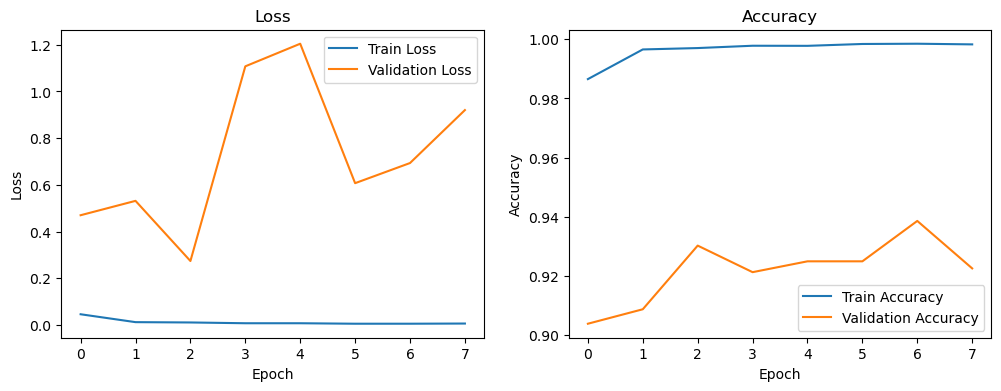

588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9327 - loss: 0.2599
Performanțe model: Acuratețe = 93.02%


In [22]:
import os
import tkinter as tk
from tkinter import scrolledtext
from datetime import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, Flatten, Input, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt

MODEL_DIR = os.path.join(".", "saved_model")
MODEL_FILE_PATH = os.path.join(MODEL_DIR, "model_traffic_final_model.h5")
LOG_DIR = os.path.join(".", "analysis_logs")

# Definirea coloanelor
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent',
           'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
           'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
           'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
           'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
           'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
           'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack', 'level']

# Funcție de grupare a etichetelor de atac în cele 5 categorii
def group_attack_label(attack):
    attack = attack.lower()
    if attack in ['satan', 'portsweep', 'nmap', 'jpsweep']:
        return 'Probe'
    elif attack in ['spy', 'phf', 'multihop', 'imap', 'guess_passwd', 'ftp_write', 'warezmaster', 'warezclient']:
        return 'R2L'
    elif attack in ['rootkit', 'perl', 'loadmodule', 'buffer_overflow']:
        return 'U2R'
    elif attack in ['teardrop', 'smurf', 'pod', 'neptune', 'land', 'back']:
        return 'DoS'
    elif attack == 'normal':
        return 'NORMAL'
    else:
        return 'NORMAL'

# Funcție de încărcare și preprocesare a datelor de antrenare
def load_and_preprocess_train_data(file_path):
    df = pd.read_csv(file_path, delimiter=',', header=None)
    df.columns = columns

    X = df.iloc[:, :-1]
    y_raw = df['attack'].apply(group_attack_label)

    label_encoders = {}
    for column in X.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column])
        label_encoders[column] = le

    label_encoder_y = LabelEncoder()
    y = label_encoder_y.fit_transform(y_raw)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
    return X_scaled, y, label_encoders, label_encoder_y, scaler

# Funcție de încărcare și preprocesare a datelor de testare
# Se returnează și raw_test_df pentru afișarea pachetelor de date în interfață
def load_and_preprocess_test_data(file_path, label_encoders, label_encoder_y, scaler):
    df = pd.read_csv(file_path, delimiter=',', header=None)
    df.columns = columns
    # Stocăm datele originale înainte de filtrare
    raw_df = df.copy()

    y_raw = df['attack'].apply(group_attack_label)
    mask_attack = y_raw.isin(label_encoder_y.classes_)
    if not mask_attack.all():
        unknown_labels = y_raw[~mask_attack].unique()
        print("Următoarele etichete de atac nu sunt prezente în setul de antrenare și vor fi eliminate:", unknown_labels)
        df = df[mask_attack]
        raw_df = raw_df[mask_attack]  # Actualizăm și raw_df
        y_raw = y_raw[mask_attack]

    X = df.iloc[:, :-1]

    for column in X.select_dtypes(include=['object']).columns:
        le = label_encoders[column]
        mask_col = X[column].isin(le.classes_)
        if not mask_col.all():
            unknown_values = X.loc[~mask_col, column].unique()
            print(f"În coloana '{column}', următoarele valori necunoscute vor fi eliminate:", unknown_values)
            X = X[mask_col]
            y_raw = y_raw[mask_col]
            raw_df = raw_df[mask_col]
        X[column] = le.transform(X[column])

    y = label_encoder_y.transform(y_raw)

    X_scaled = scaler.transform(X)
    X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
    return X_scaled, y, raw_df

# Definirea unui bloc Inception pentru date 1D
def inception_block(x, filters):
    branch1 = Conv1D(filters, kernel_size=1, padding='same', activation='relu')(x)

    branch3 = Conv1D(filters, kernel_size=1, padding='same', activation='relu')(x)
    branch3 = Conv1D(filters, kernel_size=3, padding='same', activation='relu')(branch3)

    branch5 = Conv1D(filters, kernel_size=1, padding='same', activation='relu')(x)
    branch5 = Conv1D(filters, kernel_size=5, padding='same', activation='relu')(branch5)

    branch_pool = MaxPooling1D(pool_size=3, strides=1, padding='same')(x)
    branch_pool = Conv1D(filters, kernel_size=1, padding='same', activation='relu')(branch_pool)

    x = concatenate([branch1, branch3, branch5, branch_pool], axis=-1)
    return x

# Crearea modelului VGG16IncepNet pentru date 1D
def create_vgg16incepnet_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = inception_block(x, filters=64)

    x = Conv1D(256, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv1D(256, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.summary()  # Afișează sumarul modelului în consolă
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

# Încărcare și pregătire date
train_file = "../Data/nsl-kdd/KDDTrain+.txt"
test_file = "../Data/nsl-kdd/KDDTest+.txt"

X_train, y_train, label_encoders, label_encoder_y, scaler = load_and_preprocess_train_data(train_file)
X_test, y_test, raw_test_df = load_and_preprocess_test_data(test_file, label_encoders, label_encoder_y, scaler)

num_classes = len(np.unique(y_train))

if os.path.exists(MODEL_FILE_PATH):
    model = load_model(MODEL_FILE_PATH, compile=False)
    model.summary()
    print("Modelul a fost încărcat din fișierul salvat.")
else:
    os.makedirs(MODEL_DIR, exist_ok=True)
    model = create_vgg16incepnet_model(X_train.shape[1:], num_classes)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=10, batch_size=64,
              validation_data=(X_test, y_test), callbacks=[early_stopping])
    model.save(MODEL_FILE_PATH)
    model.summary()
    print("Modelul a fost antrenat și salvat în format .h5.")

    # Afișarea curbelor de antrenare
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Evaluarea performanțelor modelului
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Performanțe model: Acuratețe = {accuracy * 100:.2f}%")

def preprocess_and_predict(data, threshold=50):
    prediction_probs = model.predict(data)[0]
    predicted_index = np.argmax(prediction_probs)
    confidence = prediction_probs[predicted_index] * 100
    if confidence < threshold:
        return "Trafic Legitim", confidence
    predicted_category = label_encoder_y.inverse_transform([predicted_index])[0]
    return f"Atac: {predicted_category}", confidence

# Funcție de salvare a atacurilor detectate într-un fișier text
def save_attack_to_file(log_file, attack_type, confidence, packet_data):
    current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    with open(log_file, 'a', encoding="utf-8") as file:
        file.write(f"{current_time}\t{attack_type}\t\t{confidence:.2f}%\n")
        file.write(f"Packet Data: {packet_data}\n")
        file.write("-"*60 + "\n")

# Interfața Tkinter pentru analiza traficului
class LiveTrafficAnalyzer:
    def __init__(self, root):
        self.root = root
        self.root.title("Live Internet Traffic Analyzer")

        self.label = tk.Label(root, text="Internet Traffic Analysis", font=("Arial", 16))
        self.label.pack(pady=10)

        # Butoane de start și stop
        self.start_button = tk.Button(root, text="Start Analysis", command=self.start_analysis)
        self.start_button.pack(pady=5)
        self.stop_button = tk.Button(root, text="Stop Analysis", command=self.stop_analysis, state="disabled")
        self.stop_button.pack(pady=5)

        # Zonă pentru istoricul clasificărilor
        self.history_text = scrolledtext.ScrolledText(root, width=80, height=10, font=("Arial", 10))
        self.history_text.pack(pady=10)
        self.history_text.insert(tk.END, "Timestamp\t\tPredicted Attack Type\t\tConfidence (%)\n")
        self.history_text.insert(tk.END, "-"*60 + "\n")

        # Zonă pentru afișarea detaliilor pachetului de date
        self.packet_text = scrolledtext.ScrolledText(root, width=80, height=10, font=("Arial", 10))
        self.packet_text.pack(pady=10)
        self.packet_text.insert(tk.END, "Detalii pachet:\n")
        self.packet_text.insert(tk.END, "-"*60 + "\n")

        self.running = False
        self.log_file = None  # Fișier pentru salvarea log-urilor

    def start_analysis(self):
        self.running = True
        self.start_button.config(state="disabled")
        self.stop_button.config(state="normal")
        # Creează un folder cu un nume bazat pe intervalul orar al începutului analizei
        os.makedirs(LOG_DIR, exist_ok=True)
        self.log_file = os.path.join(LOG_DIR, f"analysis_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt")
        self.run_analysis()

    def stop_analysis(self):
        self.running = False
        self.start_button.config(state="normal")
        self.stop_button.config(state="disabled")

    def run_analysis(self):
        if self.running:
            idx = np.random.randint(0, len(X_test))
            sample_data = X_test[idx].reshape(1, X_test.shape[1], 1)
            attack_type, confidence = preprocess_and_predict(sample_data)
            current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            # Actualizează istoricul în interfață
            self.history_text.insert(tk.END, f"{current_time}\t{attack_type}\t\t{confidence:.2f}%\n")
            self.history_text.see(tk.END)

            # Preluăm datele brute ale pachetului corespunzător indexului ales
            packet_details = raw_test_df.iloc[idx]
            # Construim un string cu pachetul de date pe un singur rând, separate prin " | "
            details_str = "Pachetul de date: " + " | ".join([f"{col}: {packet_details[col]}" for col in raw_test_df.columns])
            self.packet_text.delete("1.0", tk.END)
            self.packet_text.insert(tk.END, details_str + "\n" + "-"*60 + "\n")

            # Salvăm rezultatul analizei într-un fișier text
            save_attack_to_file(self.log_file, attack_type, confidence, details_str)

            self.root.after(3000, self.run_analysis)

# Inițializarea și rularea aplicației Tkinter
root = tk.Tk()
app = LiveTrafficAnalyzer(root)
root.mainloop()


In [26]:
import os
import tkinter as tk
from tkinter import scrolledtext
from datetime import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, Flatten, Input, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt

MODEL_DIR = os.path.join(".", "saved_model")
MODEL_FILE_PATH = os.path.join(MODEL_DIR, "model_traffic_final_model.h5")
LOG_DIR = os.path.join(".", "analysis_logs")

# Definirea coloanelor
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent',
           'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
           'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
           'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
           'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
           'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
           'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack', 'level']

# Funcție de grupare a etichetelor de atac în cele 5 categorii
def group_attack_label(attack):
    attack = attack.lower()
    if attack in ['satan', 'portsweep', 'nmap', 'jpsweep']:
        return 'Probe'
    elif attack in ['spy', 'phf', 'multihop', 'imap', 'guess_passwd', 'ftp_write', 'warezmaster', 'warezclient']:
        return 'R2L'
    elif attack in ['rootkit', 'perl', 'loadmodule', 'buffer_overflow']:
        return 'U2R'
    elif attack in ['teardrop', 'smurf', 'pod', 'neptune', 'land', 'back']:
        return 'DoS'
    elif attack == 'normal':
        return 'NORMAL'
    else:
        return 'NORMAL'

# Funcție de încărcare și preprocesare a datelor de antrenare
def load_and_preprocess_train_data(file_path):
    df = pd.read_csv(file_path, delimiter=',', header=None)
    df.columns = columns

    X = df.iloc[:, :-1]
    y_raw = df['attack'].apply(group_attack_label)

    label_encoders = {}
    for column in X.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column])
        label_encoders[column] = le

    label_encoder_y = LabelEncoder()
    y = label_encoder_y.fit_transform(y_raw)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
    return X_scaled, y, label_encoders, label_encoder_y, scaler

# Funcție de încărcare și preprocesare a datelor de testare
# Se returnează și raw_test_df pentru afișarea pachetelor de date în interfață
def load_and_preprocess_test_data(file_path, label_encoders, label_encoder_y, scaler):
    df = pd.read_csv(file_path, delimiter=',', header=None)
    df.columns = columns
    # Stocăm datele originale înainte de filtrare
    raw_df = df.copy()

    y_raw = df['attack'].apply(group_attack_label)
    mask_attack = y_raw.isin(label_encoder_y.classes_)
    if not mask_attack.all():
        unknown_labels = y_raw[~mask_attack].unique()
        print("Următoarele etichete de atac nu sunt prezente în setul de antrenare și vor fi eliminate:", unknown_labels)
        df = df[mask_attack]
        raw_df = raw_df[mask_attack]  # Actualizăm și raw_df
        y_raw = y_raw[mask_attack]

    X = df.iloc[:, :-1]

    for column in X.select_dtypes(include=['object']).columns:
        le = label_encoders[column]
        mask_col = X[column].isin(le.classes_)
        if not mask_col.all():
            unknown_values = X.loc[~mask_col, column].unique()
            print(f"În coloana '{column}', următoarele valori necunoscute vor fi eliminate:", unknown_values)
            X = X[mask_col]
            y_raw = y_raw[mask_col]
            raw_df = raw_df[mask_col]
        X[column] = le.transform(X[column])

    y = label_encoder_y.transform(y_raw)

    X_scaled = scaler.transform(X)
    X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
    return X_scaled, y, raw_df

# Definirea unui bloc Inception pentru date 1D
def inception_block(x, filters):
    branch1 = Conv1D(filters, kernel_size=1, padding='same', activation='relu')(x)

    branch3 = Conv1D(filters, kernel_size=1, padding='same', activation='relu')(x)
    branch3 = Conv1D(filters, kernel_size=3, padding='same', activation='relu')(branch3)

    branch5 = Conv1D(filters, kernel_size=1, padding='same', activation='relu')(x)
    branch5 = Conv1D(filters, kernel_size=5, padding='same', activation='relu')(branch5)

    branch_pool = MaxPooling1D(pool_size=3, strides=1, padding='same')(x)
    branch_pool = Conv1D(filters, kernel_size=1, padding='same', activation='relu')(branch_pool)

    x = concatenate([branch1, branch3, branch5, branch_pool], axis=-1)
    return x

# Crearea modelului VGG16IncepNet pentru date 1D
def create_vgg16incepnet_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)  # Adăugare Dropout pentru regularizare

    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)  # Adăugare Dropout pentru regularizare

    x = inception_block(x, filters=64)
    x = Dropout(0.3)(x)  # Adăugare Dropout pentru regularizare

    x = Conv1D(256, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv1D(256, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)  # Adăugare Dropout pentru regularizare

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.summary()  # Afișează sumarul modelului în consolă

    # Ajustarea ratei de învățare
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

# Încărcare și pregătire date
train_file = "../Data/nsl-kdd/KDDTrain+.txt"
test_file = "../Data/nsl-kdd/KDDTest+.txt"

X_train, y_train, label_encoders, label_encoder_y, scaler = load_and_preprocess_train_data(train_file)
X_test, y_test, raw_test_df = load_and_preprocess_test_data(test_file, label_encoders, label_encoder_y, scaler)

num_classes = len(np.unique(y_train))

if os.path.exists(MODEL_FILE_PATH):
    model = load_model(MODEL_FILE_PATH, compile=False)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
    model.summary()
    print("Modelul a fost încărcat din fișierul salvat.")
else:
    os.makedirs(MODEL_DIR, exist_ok=True)
    model = create_vgg16incepnet_model(X_train.shape[1:], num_classes)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32,
              validation_data=(X_test, y_test), callbacks=[early_stopping])
    model.save(MODEL_FILE_PATH)
    model.summary()
    print("Modelul a fost antrenat și salvat în format .h5.")

    # Afișarea curbelor de antrenare
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Evaluarea performanțelor modelului
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Performanțe model: Acuratețe = {accuracy * 100:.2f}%")

def preprocess_and_predict(data, threshold=50):
    prediction_probs = model.predict(data)[0]
    predicted_index = np.argmax(prediction_probs)
    confidence = prediction_probs[predicted_index] * 100
    if confidence < threshold:
        return "Trafic Legitim", confidence
    predicted_category = label_encoder_y.inverse_transform([predicted_index])[0]
    return f"Atac: {predicted_category}", confidence

# Funcție de salvare a atacurilor detectate într-un fișier text
def save_attack_to_file(log_file, attack_type, confidence, packet_data):
    current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    with open(log_file, 'a', encoding="utf-8") as file:
        file.write(f"{current_time}\t{attack_type}\t\t{confidence:.2f}%\n")
        file.write(f"Packet Data: {packet_data}\n")
        file.write("-"*60 + "\n")

# Interfața Tkinter pentru analiza traficului
class LiveTrafficAnalyzer:
    def __init__(self, root):
        self.root = root
        self.root.title("Live Internet Traffic Analyzer")

        self.label = tk.Label(root, text="Internet Traffic Analysis", font=("Arial", 16))
        self.label.pack(pady=10)

        # Butoane de start și stop
        self.start_button = tk.Button(root, text="Start Analysis", command=self.start_analysis)
        self.start_button.pack(pady=5)
        self.stop_button = tk.Button(root, text="Stop Analysis", command=self.stop_analysis, state="disabled")
        self.stop_button.pack(pady=5)

        # Zonă pentru istoricul clasificărilor
        self.history_text = scrolledtext.ScrolledText(root, width=80, height=10, font=("Arial", 10))
        self.history_text.pack(pady=10)
        self.history_text.insert(tk.END, "Timestamp\t\tPredicted Attack Type\t\tConfidence (%)\n")
        self.history_text.insert(tk.END, "-"*60 + "\n")

        # Zonă pentru afișarea detaliilor pachetului de date
        self.packet_text = scrolledtext.ScrolledText(root, width=80, height=10, font=("Arial", 10))
        self.packet_text.pack(pady=10)
        self.packet_text.insert(tk.END, "Detalii pachet:\n")
        self.packet_text.insert(tk.END, "-"*60 + "\n")

        self.running = False
        self.log_file = None  # Fișier pentru salvarea log-urilor

    def start_analysis(self):
        self.running = True
        self.start_button.config(state="disabled")
        self.stop_button.config(state="normal")
        # Creează un folder cu un nume bazat pe intervalul orar al începutului analizei
        os.makedirs(LOG_DIR, exist_ok=True)
        self.log_file = os.path.join(LOG_DIR, f"analysis_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt")
        self.run_analysis()

    def stop_analysis(self):
        self.running = False
        self.start_button.config(state="normal")
        self.stop_button.config(state="disabled")

    def run_analysis(self):
        if self.running:
            idx = np.random.randint(0, len(X_test))
            sample_data = X_test[idx].reshape(1, X_test.shape[1], 1)
            attack_type, confidence = preprocess_and_predict(sample_data)
            current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            # Actualizează istoricul în interfață
            self.history_text.insert(tk.END, f"{current_time}\t{attack_type}\t\t{confidence:.2f}%\n")
            self.history_text.see(tk.END)

            # Preluăm datele brute ale pachetului corespunzător indexului ales
            packet_details = raw_test_df.iloc[idx]
            # Construim un string cu pachetul de date pe un singur rând, separate prin " | "
            details_str = "Pachetul de date: " + " | ".join([f"{col}: {packet_details[col]}" for col in raw_test_df.columns])
            self.packet_text.delete("1.0", tk.END)
            self.packet_text.insert(tk.END, details_str + "\n" + "-"*60 + "\n")

            # Salvăm rezultatul analizei într-un fișier text
            save_attack_to_file(self.log_file, attack_type, confidence, details_str)

            self.root.after(3000, self.run_analysis)

# Inițializarea și rularea aplicației Tkinter
root = tk.Tk()
app = LiveTrafficAnalyzer(root)
root.mainloop()


În coloana 'attack', următoarele valori necunoscute vor fi eliminate: ['saint' 'mscan' 'apache2' 'snmpgetattack' 'processtable' 'httptunnel'
 'ps' 'snmpguess' 'mailbomb' 'named' 'sendmail' 'xterm' 'worm' 'xlock'
 'xsnoop' 'sqlattack' 'udpstorm']


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 42, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 42, 64)    │        256 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 42, 64)    │     12,352 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 21, 64)    │          0 │ conv1d_7[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 21, 128)   │     24,704 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 21, 128)   │     49,280 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 10, 128)   │          0 │ conv1d_9[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 10, 64)    │      8,256 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 10, 64)    │      8,256 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 10, 128)   │          0 │ max_pooling1d_3[… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 10, 64)    │      8,256 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 10, 64)    │     12,352 │ conv1d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 10, 64)    │     20,544 │ conv1d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 10, 64)    │      8,256 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10, 256)   │          0 │ conv1d_10[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_12[0][0],  │
│                     │                   │            │ conv1d_14[0][0],  │
│                     │                   │            │ conv1d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 10, 256)   │    196,864 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 10, 256)   │    196,864 │ conv1d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 5, 256)    │          0 │ conv1d_17[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1280)      │          0 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    655,872 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ dense_2[0][0]   

 Total params: 1,204,677 (4.60 MB)

 Trainable params: 1,204,677 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

Modelul a fost încărcat din fișierul salvat.
588/588 ━━━━━━━━━━━━━━━━━━━━ 3:46 386ms/step - accuracy: 0.9688 - loss: 0.07 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9591 - loss: 0.1229   ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9524 - loss: 0.15 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9507 - loss: 0.17 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9491 - loss: 0.18 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9481 - loss: 0.19 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9470 - loss: 0.19 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9456 - loss: 0.20 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9442 - loss: 0.21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9427 - loss: 0.21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9414 - loss: 0.22 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9404 - loss: 0.22 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9398 - loss: 0.23 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9390 - loss: 0.23 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/s